In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 512 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


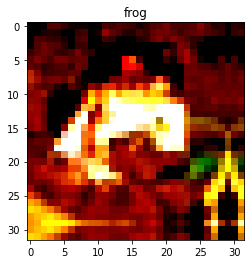

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine-batch512-lr03.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.3
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 2.6026643684932163, Test loss 1.743850153684616, Train accuracy 21.095078682412908, Test accuracy 35.720932960510254, Cost 64.71624279022217 s
Epoch 2, Train loss 1.5631035858271074, Test loss 1.3689791560173035, Train accuracy 42.11660669287857, Test accuracy 50.25850200653076, Cost 74.63840508460999 s
Epoch 3, Train loss 1.3081835374540212, Test loss 1.1333390474319458, Train accuracy 52.537164454557455, Test accuracy 59.341107559204104, Cost 74.62822651863098 s
Epoch 4, Train loss 1.0492468251257527, Test loss 0.853520268201828, Train accuracy 62.54384566326531, Test accuracy 69.716796875, Cost 74.49125218391418 s
Epoch 5, Train loss 0.844208474061927, Test loss 0.7251138836145401, Train accuracy 70.1941547004544, Test accuracy 74.67830886840821, Cost 74.50680661201477 s
Model saved in epoch 5
Epoch 6, Train loss 0.6981330288916218, Test loss 0.6115534752607346, Train accuracy 75.69308417184013, Test accuracy 78.97231178283691, Cost 74.54372930526733 s
Epoch 7, T

Epoch 51, Train loss 0.0301580451029752, Test loss 0.3700766295194626, Train accuracy 98.89465269750478, Test accuracy 91.9881664276123, Cost 74.62583899497986 s
Epoch 52, Train loss 0.029480242341452717, Test loss 0.37833630591630935, Train accuracy 98.96535624289999, Test accuracy 92.0467601776123, Cost 74.81082248687744 s
Epoch 53, Train loss 0.02881941919652175, Test loss 0.36591840982437135, Train accuracy 98.95738430412449, Test accuracy 92.14556503295898, Cost 74.95809149742126 s
Epoch 54, Train loss 0.027173725641047468, Test loss 0.40044521987438203, Train accuracy 99.05219346649793, Test accuracy 91.84397964477539, Cost 74.92547178268433 s
Epoch 55, Train loss 0.027448922870870755, Test loss 0.35736163705587387, Train accuracy 99.05617943588568, Test accuracy 92.3776424407959, Cost 74.45138335227966 s
Model saved in epoch 55
Epoch 56, Train loss 0.02553898683863179, Test loss 0.36593448370695114, Train accuracy 99.11388101383132, Test accuracy 92.24437026977539, Cost 74.65746

Epoch 100, Train loss 0.007496323374133291, Test loss 0.38492212295532224, Train accuracy 99.74271517383809, Test accuracy 92.99574928283691, Cost 74.56952333450317 s
Model saved in epoch 100
Epoch 101, Train loss 0.008440770975038486, Test loss 0.39305356070399283, Train accuracy 99.72193122396664, Test accuracy 93.04917259216309, Cost 74.55033445358276 s
Epoch 102, Train loss 0.012040413623884777, Test loss 0.41977456510066985, Train accuracy 99.59438020355847, Test accuracy 92.33341026306152, Cost 74.68783235549927 s
Epoch 103, Train loss 0.008335516843303315, Test loss 0.39472179263830187, Train accuracy 99.72392420866052, Test accuracy 92.6815258026123, Cost 74.57392811775208 s
Epoch 104, Train loss 0.006710040913146388, Test loss 0.3850475251674652, Train accuracy 99.78172076478296, Test accuracy 93.30307884216309, Cost 74.476797580719 s
Epoch 105, Train loss 0.005142149175113371, Test loss 0.41077949553728105, Train accuracy 99.81759448927276, Test accuracy 93.02504615783691, Co

Epoch 148, Train loss 0.004470455774898422, Test loss 0.41070849895477296, Train accuracy 99.84151030559929, Test accuracy 93.1847427368164, Cost 74.65812635421753 s
Epoch 149, Train loss 0.002804295291214806, Test loss 0.4185402110219002, Train accuracy 99.91230867346938, Test accuracy 93.17038154602051, Cost 74.57706570625305 s
Epoch 150, Train loss 0.0024744074914024726, Test loss 0.4257992684841156, Train accuracy 99.91819272722516, Test accuracy 93.2996322631836, Cost 74.61074352264404 s
Model saved in epoch 150
Epoch 151, Train loss 0.002725700266618871, Test loss 0.40510379076004027, Train accuracy 99.90832270408163, Test accuracy 93.5167739868164, Cost 74.74706697463989 s
Epoch 152, Train loss 0.001933631714898499, Test loss 0.40324077010154724, Train accuracy 99.94419642857143, Test accuracy 93.6707260131836, Cost 74.77278351783752 s
Epoch 153, Train loss 0.0026984789655383496, Test loss 0.4481006234884262, Train accuracy 99.90727880049725, Test accuracy 93.24563407897949, Cos

Epoch 197, Train loss 0.00045424865083059187, Test loss 0.4328721910715103, Train accuracy 99.99202806122449, Test accuracy 93.86488990783691, Cost 74.81312346458435 s
Epoch 198, Train loss 0.0006070053505769762, Test loss 0.43061190843582153, Train accuracy 99.98405612244898, Test accuracy 93.67417259216309, Cost 74.54926419258118 s
Epoch 199, Train loss 0.0005739613330308425, Test loss 0.4401131421327591, Train accuracy 99.9820631377551, Test accuracy 93.75344657897949, Cost 74.62229132652283 s
Epoch 200, Train loss 0.0005609652653405721, Test loss 0.4353976741433144, Train accuracy 99.98405612244898, Test accuracy 93.857421875, Cost 74.73488116264343 s
Model saved in epoch 200
Epoch 201, Train loss 0.00042347211307728407, Test loss 0.4439505562186241, Train accuracy 99.98804209183673, Test accuracy 93.6328125, Cost 74.64967060089111 s
Epoch 202, Train loss 0.0005292732234270911, Test loss 0.43845722526311875, Train accuracy 99.98804209183673, Test accuracy 93.9051010131836, Cost 74.

Epoch 246, Train loss 0.00012219032578750743, Test loss 0.4364381477236748, Train accuracy 99.99601403061224, Test accuracy 93.9171646118164, Cost 74.55102348327637 s
Epoch 247, Train loss 0.00010996952236920912, Test loss 0.43817547112703326, Train accuracy 99.99800701530613, Test accuracy 93.8781021118164, Cost 74.50860524177551 s
Epoch 248, Train loss 7.075162334424059e-05, Test loss 0.43836258798837663, Train accuracy 100.0, Test accuracy 93.9171646118164, Cost 74.71886444091797 s
Epoch 249, Train loss 0.00012683793672100104, Test loss 0.436685349047184, Train accuracy 99.99601403061224, Test accuracy 94.0320541381836, Cost 74.75552082061768 s
Epoch 250, Train loss 0.0001593476497071012, Test loss 0.4367749720811844, Train accuracy 99.99402104591837, Test accuracy 93.93784446716309, Cost 74.58654165267944 s
Model saved in epoch 250
Epoch 251, Train loss 0.0001508968238925133, Test loss 0.44196132868528365, Train accuracy 99.99800701530613, Test accuracy 93.984375, Cost 74.541471481

Epoch 296, Train loss 4.3260224849606805e-05, Test loss 0.4393020153045654, Train accuracy 100.0, Test accuracy 94.1124771118164, Cost 74.80494403839111 s
Epoch 297, Train loss 4.0130691758702373e-05, Test loss 0.4388204887509346, Train accuracy 100.0, Test accuracy 94.1613052368164, Cost 74.71873688697815 s
Epoch 298, Train loss 3.164237573145681e-05, Test loss 0.4385936677455902, Train accuracy 100.0, Test accuracy 94.1515396118164, Cost 74.71965479850769 s
Epoch 299, Train loss 5.3621448927867964e-05, Test loss 0.4398384004831314, Train accuracy 99.99800701530613, Test accuracy 94.1320083618164, Cost 74.7113904953003 s
Epoch 300, Train loss 3.3977825282539813e-05, Test loss 0.4398368462920189, Train accuracy 100.0, Test accuracy 94.1906021118164, Cost 74.6624743938446 s
Model saved in epoch 300
Epoch 301, Train loss 4.8995291066074394e-05, Test loss 0.4408059477806091, Train accuracy 99.99800701530613, Test accuracy 94.16015625, Cost 74.8051609992981 s
Epoch 302, Train loss 3.228682

Epoch 348, Train loss 1.7830956084931037e-05, Test loss 0.4450409486889839, Train accuracy 100.0, Test accuracy 94.111328125, Cost 74.4803740978241 s
Epoch 349, Train loss 2.0380042412528254e-05, Test loss 0.4454564332962036, Train accuracy 100.0, Test accuracy 94.130859375, Cost 74.68516659736633 s
Epoch 350, Train loss 1.7637780939826465e-05, Test loss 0.4452829122543335, Train accuracy 100.0, Test accuracy 94.140625, Cost 74.70246195793152 s
Model saved in epoch 350
Epoch 351, Train loss 2.392455587132459e-05, Test loss 0.44571428894996645, Train accuracy 100.0, Test accuracy 94.130859375, Cost 74.72356581687927 s
Epoch 352, Train loss 1.506630055225324e-05, Test loss 0.4456989511847496, Train accuracy 100.0, Test accuracy 94.130859375, Cost 74.47599387168884 s
Epoch 353, Train loss 1.2019848179418157e-05, Test loss 0.44554183781147005, Train accuracy 100.0, Test accuracy 94.150390625, Cost 74.71379232406616 s
Epoch 354, Train loss 3.148441712315913e-05, Test loss 0.4467923820018768

Epoch 401, Train loss 1.2683305030526642e-05, Test loss 0.4472548931837082, Train accuracy 100.0, Test accuracy 94.1015625, Cost 74.73963022232056 s
Epoch 402, Train loss 1.5089424595994295e-05, Test loss 0.4473154678940773, Train accuracy 100.0, Test accuracy 94.1015625, Cost 74.66773104667664 s
Epoch 403, Train loss 1.4175672939885846e-05, Test loss 0.4472644031047821, Train accuracy 100.0, Test accuracy 94.1015625, Cost 74.67198514938354 s
Epoch 404, Train loss 1.276796976006673e-05, Test loss 0.4472875759005547, Train accuracy 100.0, Test accuracy 94.1015625, Cost 74.91836905479431 s
Epoch 405, Train loss 1.4425488755556885e-05, Test loss 0.4472735568881035, Train accuracy 100.0, Test accuracy 94.091796875, Cost 74.78351902961731 s
Model saved in epoch 405
Epoch 406, Train loss 1.4639366103280309e-05, Test loss 0.4472503989934921, Train accuracy 100.0, Test accuracy 94.091796875, Cost 74.69851517677307 s
Epoch 407, Train loss 1.2674884765587825e-05, Test loss 0.44746274650096896, T

Epoch 454, Train loss 9.484234602282692e-06, Test loss 0.4482133165001869, Train accuracy 100.0, Test accuracy 94.08203125, Cost 74.6550874710083 s
Epoch 455, Train loss 1.209120224518524e-05, Test loss 0.4481992185115814, Train accuracy 100.0, Test accuracy 94.072265625, Cost 74.66264748573303 s
Model saved in epoch 455
Epoch 456, Train loss 1.15369541751246e-05, Test loss 0.44819280356168745, Train accuracy 100.0, Test accuracy 94.072265625, Cost 74.6454086303711 s
Epoch 457, Train loss 1.1328909262344348e-05, Test loss 0.44817632585763933, Train accuracy 100.0, Test accuracy 94.072265625, Cost 74.63850092887878 s
Epoch 458, Train loss 1.4776566398124339e-05, Test loss 0.44817131012678146, Train accuracy 100.0, Test accuracy 94.072265625, Cost 74.7318844795227 s
Epoch 459, Train loss 5.322715817989811e-05, Test loss 0.4482662439346313, Train accuracy 99.99601403061224, Test accuracy 94.072265625, Cost 74.55923891067505 s
Epoch 460, Train loss 1.3046563511853511e-05, Test loss 0.44827

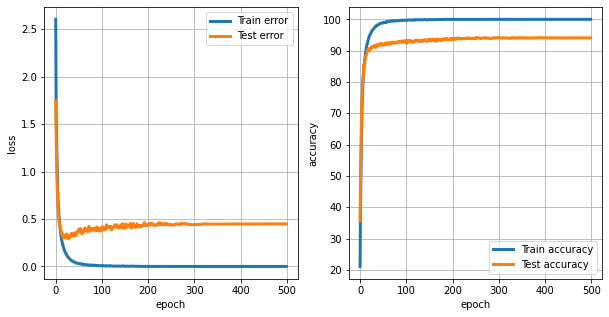

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 94.072265625
